# 人脸关键点检测 - Face Keypoint Detection

该项目将定义和训练一个用于执行人脸关键点检测的卷积神经网络，并使用计算机视觉技术来转换人脸图像. (注: 本项目算法核心参考了[论文"Facial Key Points Detection using Deep Convolutional Neural Network - NaimishNet"](https://arxiv.org/pdf/1710.00977.pdf))

项目的第一步是加载和可视化将使用的数据。首先，我们来看一些图像和相应的人脸关键点示例(下图1)。**人脸关键点**(也称为人脸特征点)指的是上面图像中每个人脸上显示的洋红色的小点。在每个训练和测试图像中，有一个人脸和**68**个关键点，其中，人脸的坐标是(x,y)。这些关键点标记了人脸的重要区域: 眼睛，嘴角，鼻子等。这些关键点与许多应用相关，如人脸滤波、情感识别、姿势识别等。在这里，它们是编号的，你可以看到特定范围的点与该人脸的不同部分相匹配(下图2)。

<img src='images/key_pts_example.png' width=35% height=35%/><img src='images/landmarks_numbered.jpg' width=25% height=25%/>

---
# Part 1

## 1.加载和可视化数据

使用任何数据集的第一步, 都是要熟悉的数据(这些是模型要学习的对象). 此外, 还需要加载人脸及其关键点的图像, 并将其可视化. 这个项目中的图像数据是从[YouTube人脸数据集](https://www.cs.tau.ac.il/~wolf/ytfaces/)中提取的, 其中包含YouTube视频中的人脸视频, 通过一些处理步骤, 可以将这些视频转换为包含一个人脸和对应关键点的图像帧集.

#### 训练数据和测试数据

该人脸关键点数据集由5770张彩色图像组成, 所有这些图像都被分成**训练数据集**(3462张, 在创建用来预测关键点的模型时使用)与**测试数据集**(2308张, 用于测试该模型的准确性). 有关此数据集中图像和关键点的信息汇总在CSV文件中, 可以使用`pandas`读取这些文件。接着, 我们读取训练CSV, 并在(N,2)数组中获取注释, 其中N是关键点的数量, 2是关键点坐标(x,y)的维度。

首先, 在着手行动之前, 我们要加载图像数据, 这些数据存储在一个压缩文件中. 在下面的单元格中，我们可以通过它的URL访问该压缩文件，并将数据解压缩到与工作区Home目录分开的`/data/`目录中。

In [76]:
# 以下代码在terminal中执行(不在python环境中执行).
# !mkdir /data # sudo, -p mastermas
# !wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
# 直接从本地加载zip数据(另外下载), 不从此处下载;
!unzip -n ./data/train-test-data.zip -d ./data
# Archive:  ./data/train-test-data.zip
#   creating: ./data/test/
#  inflating: ./data/test/Abdel_Aziz_Al-Hakim_00.jpg
# ...

In [1]:
# 导入库, helper代码.
# !pip install opencv-python # cv2
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2  # pip install opencv-python;
# 加载训练数据, 并显示有关该数据的一些统计数据, 最后确保它已正确加载!
key_pts_frame = pd.read_csv('./data/training_frames_keypoints.csv')
n = 0                                              # 第index=0张图片;
image_name = key_pts_frame.iloc[n, 0]              # 第0列是图片名;
key_pts    = key_pts_frame.iloc[n, 1:].as_matrix() # 第一列及以后: 共136列, 68个点的x和y的坐标;
key_pts    = key_pts.astype('float').reshape(-1, 2)# 换成任意行数及2列的形状;
print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[  45.   98.]
 [  47.  106.]
 [  49.  110.]
 [  53.  119.]]
Number of images:  3462


## 2.观察一些图像

In [2]:
# 接收image和关键点, 并将它们绘制出来。接收的图像尺寸不同，人脸也不同.
# 用这些图像训练神经网络时, 需要标准化图像的形状。
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    # 设置绘制时的一些参数, 前两个是x列和y列;
    plt.scatter(key_pts[:,0], key_pts[:,1], s=20, marker='.', c='m')

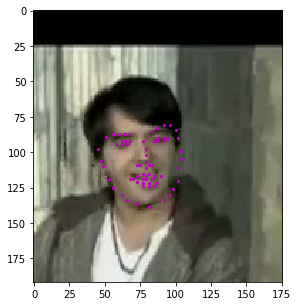

In [3]:
# Display a few different types of images by changing the index n
# select an image by index in our data frame
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)
# 开始绘制样例图像;
plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('./data/training/', image_name)), key_pts)
plt.show()

## 3.Dataset类, 与transform转换

为了准备训练我们的数据, 我们使用PyTorch的Dataset类, 这段代码大部分都是[PyTorch数据加载教程](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html)中代码的修改.

#### Dataset类

``torch.utils.data.Dataset``是一个表示数据集的抽象类, 这个类可以让我们批量加载图像/关键点数据, 并统一地将转换应用于我们的数据, 例如, 为了训练神经网络, 重新缩放和归一化化图像.

你的自定义数据集应继承``Dataset``并覆盖以下方法：

-  ``__len__``,从而使``len(dataset)``返回数据集的大小。

-  ``__getitem__``, 用于支持索引，使``dataset[i]``可用于获取第i个图像/关键点数据样本。

接下来，让我们为人脸关键点数据集创建一个dataset类, 我们要读取``__init__``中的CSV文件, 但将图像的读取留给``__getitem__``. 这就是**高效存储**, 因为所有图像都不是一次性存储在内存中, 而是根据需要读取. 我们的数据集样例将是一个字典``{'image':image, 'keypoints':key_pts}``, 该数据集将采用可选参数``transform``, 这样的话, 任何所需的处理都可以应用于样本. 在下一部分, 我们要学习的是``transform``的有效性.

In [4]:
# !pip install torch
from torch.utils.data import Dataset, DataLoader

# 定义一个FacialKeypointsDataset类(继承自Dataset), 用于高效存储数据集中的样例;
class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """ Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir      = root_dir
        self.transform     = transform

    def __len__(self):
        return len(self.key_pts_frame)

    # 现取现用的一个函数;
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.key_pts_frame.iloc[idx, 0])
        image = mpimg.imread(image_name)
        # If image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):  # alpha属性;
            image = image[:,:,0:3]
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample  = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)
        # 字典对象;
        return sample

现在，我们已经定义了这个类，接下来，我们要做的是实例化该数据集并显示一些图像。

In [5]:
# Construct the dataset object;
face_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv', root_dir='./data/training/')
# Print some stats about the dataset;
print('Length of dataset: ', len(face_dataset))  # __len__属性, python规则;

Length of dataset:  3462


0 (167, 163, 3) (68, 2)


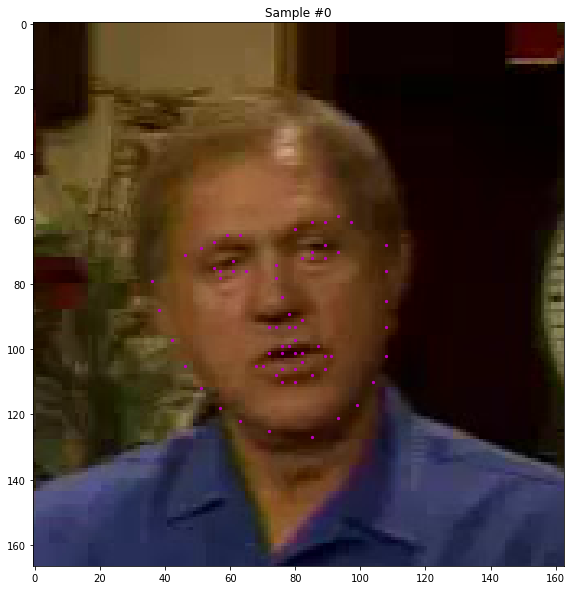

In [6]:
# Display a few of the images from the dataset;
num_to_display = 1 # 3
for i in range(num_to_display):
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]
    # Print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)
    # 绘图设定;
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    # Using the same display function, defined earlier;
    show_keypoints(sample['image'], sample['keypoints'])

## 4A.转换(预处理数据)

现在，上面的图像尺寸不同，但是，神经网络通常期望的是标准化的图像。因此，我们需要固定的尺寸、颜色范围和坐标的标准化范围。对于PyTorch来说，还需要把numpy列表和数组转换为Tensors。

因此，我们需要编写一些预处理代码。
下面，创建四个转换：

-  ``Normalize``: 将彩色图像转换为范围为[0,1]的灰度值，并将关键点标准化为约[-1,1]的范围
-  ``Rescale``: 将图像重新缩放到所需尺寸。
-  ``RandomCrop``: 随机裁剪图像。
-  ``ToTensor``: 将numpy图像转换为torch图像。


我们将它们编写为可调用类而不是简单函数，这样，每次调用时都不需要传递转换的参数。 为此，我们只需要实现 ``__call__`` 方法就可以了。如果我们需要传入参数，还需要实现``__init__``方法。 我们可以使用类似下面的转换：

```python
tx = Transform(params)
transformed_sample = tx(sample)
```

请注意以下这些转换通常是如何应用于图像及其关键点。

In [7]:
#!conda install -c conda-forge torchvision
# !pip install torchvision
import torch
from torchvision import transforms, utils
# tranforms

# 转换值;
class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0

        return {'image': image_copy, 'keypoints': key_pts_copy}

# 重新缩排尺寸;
class Rescale(object):
    """ Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}

# 随机裁剪;
class RandomCrop(object):
    """ Crop randomly the image in a sample.
    Args:
        output_size (tuple or int): Desired output size. If int, square crop is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top:top+new_h, left:left+new_w]
        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}

# 转换成Tensor;
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image), 'keypoints': torch.from_numpy(key_pts)}

## 4B.测试转换

接下来，需要对这些转换进行测试，确保它们按预期运行。查看每个转换时，请注意，在这里，**顺序非常重要**。

例如，你不能用一个小于原始图像的值来裁剪图像，而且原始图像的尺寸会有所不同(具体原因看下面"但是")。

但是，如果首先选择重新缩放原始图像，则可以将其裁剪为小于重新缩放尺寸的任何尺寸。

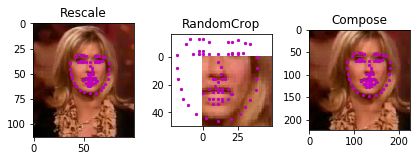

In [8]:
# test out some of these transforms
rescale  = Rescale(100)
crop     = RandomCrop(50)
composed = transforms.Compose([Rescale(250), RandomCrop(224)])
# apply the transforms to a sample image
test_num = 500
sample   = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

## 5.创建转换后的数据集

下面，我们需要使用转换获取相同形状的灰度图像。通过输出结果数据的形状来验证转换的工作原理（输出的几个示例应该显示出一致的张量大小）。

In [9]:
# Define the data tranform, order matters! i.e. rescaling should come before a smaller crop.
# 先定义一个transforms的混合对象;
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])
# Create the transformed dataset, 注意transform参数, 不再是None;
transformed_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                        root_dir='./data/training/', transform=data_transform)

In [10]:
# Print some stats about the transformed data, 此处, 即测试Test集大小;
print('Number of images: ', len(transformed_dataset))
# Make sure the sample tensors are the expected size;
for i in range(5):
    sample = transformed_dataset[i]
    # 图像Tensor数据尺寸(颜色,高,宽), 脸部keypoints数据尺寸;
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [11]:
# This cell is only for the activation of notebook: keep the cell doing something, prevent notebook to sleep.
print('Number of images: ', len(transformed_dataset))

Number of images:  3462


## 6.数据迭代与批处理

现在, 我们使用``for``循环迭代这些数据, 但是我们错过了很多PyTorch的数据集功能, 特别是下列这些功能:

-  批量处理数据,
-  置乱数据,
-  使用``multiprocessing``程序并行加载数据.

而``torch.utils.data.DataLoader``是一个提供所有这些功能的迭代器. 

在*下一个*notebook中，需要批量加载数据来训练神经网络时，我们就会看到它的这个作用!

---

## 7.准备训练神经网络

So far so good, 已经加载和预处理(转换)好了数据，这为构建一个用于训练这些数据的神经网络做好了准备.

在下一个notebook中, 将创建一个用于人脸关键点检测的CNN.

---
# Part 2

## 8.定义卷积神经网络（CNN）

查看正在使用的数据之后, 了解图像与关键点的形状, 接下来, 就可以定义一个可以从这些数据中*学习*("模式匹配")的卷积神经网络.

在这个notebook和`models.py`中, TodoList是:
1. 定义一个CNN, 把图像作为输入, 把关键点作为输出;
2. 构造转换后的FaceKeypointsDataset对象(与以前一样);
3. 使用训练数据训练这个CNN, 并记录损失情况;
4. 查看训练模型在测试数据上的执行情况;
5. 如有必要, 请修改CNN结构并模拟超参数, 使其*表现良好*;

**注**: 什么是*表现良好*? “表现良好”意味着该模型的损失在训练期间有所降低(即更加拟合所给的数据)，**而且**该模型应用于测试图像数据时, 会产生与每个人脸的真实关键点紧密匹配的关键点(即不仅仅是记牢了训练数据, 还有泛化能力), notebook中会有这样的例子.

---

## 9.CNN架构

CNN是由下列几种类型的层(网络结构)定义的(回想一下):

* 卷积层
* 最大池化层
* 全连接层

你需要使用上述层, 而且我们建议你添加多个卷积层以及防止过度拟合的dropout层等. 此外, 你还可以查看一些关键点检测的文献, 如[论文"Facial Key Points Detection using Deep Convolutional Neural Network - NaimishNet"](https://arxiv.org/pdf/1710.00977.pdf), 帮助你确定该网络的结构.


### TODO: 在`models.py`文件中定义你的模型

此文件大部分为空, 但其中包含预期名称和一些用于创建模型的TODO事项.

---

## 10.PyTorch神经网络

要在PyTorch中定义神经网络, 你可以在函数`__init__`中定义一个模型的各个层, 并定义一个网络的前馈行为(PyTorch特性), 该网络会在函数`forward`中使用这些初始化的层, 而该函数会接收输入图像张量`x`(之前的转换函数`ToTensor()`). 此Net类的结构如下所示, 由你来填充.

**注意**: 在训练期间, PyTorch能够通过跟踪网络的前馈行为并使用`autograd`来计算该网络中权重的更新, 以执行反向传播.

#### a.在` __init__`中定义层:

提醒一下, 卷积层与池化层可以像这样来定义(在`__init__`中):

```python
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)
# maxpool that uses a square window of kernel_size=2, stride=2
self.pool  = nn.MaxPool2d(2, 2)
```

#### b.引用`forward`中的层:

然后在这样的`forward`函数中引用, 其中卷积1层在应用最大池化之前应用了ReLu激活函数:

```python
x = self.pool(F.relu(self.conv1(x)))
```

最佳做法是把在训练过程中权重发生变化的任何层放置在`__init__`中, 并在`forward`函数中引用它们, 所有始终以相同方式运行的层或函数(例如预定义的激活函数)应*只*出现在`PyTorch`的`forward`函数中.

#### c.为什么要用models.py文件

因为要在`models.py`文件中定义该CNN网络, 便于在此项目目录中的不同notebook中按名称保存和加载你定义的任何模型. 例如, 通过在`models.py`中定义名为`Net`的CNN类, 通过简单地导入该类并实例化模型(Python语法, 与对象), 就可以在此notebook和其他notebook中创建相同的体系结构(即模块化):

```python
from models import Net
net = Net()
```

<div class="alert alert-info">注意: 工作区会在持续30分钟的不活动状态后, 自动关闭连接, 包括训练时出现不活动状态, 使用下面的代码段可以在训练期间保持工作区的活动状态, 下面导入了active_session上下文管理器:
</div>

```python
from workspace_utils import active_session
with active_session():
    train_model(num_epochs)
```


In [14]:
# 库: import the usual resources;
# !pip install requests
import sys
sys.path.append('/Users/univesre/miniconda3/lib/python3.6/site-packages')
import matplotlib.pyplot as plt
import numpy as np
# 库: import utilities to keep workspaces alive during model training;
from workspace_utils import active_session
# Eatch for any changes in 'model.py', if it changes, re-load it automatically;
%load_ext autoreload
%autoreload 2

In [15]:
!python -V

Python 3.6.0 :: Continuum Analytics, Inc.


In [36]:
import sys
sys.executable
sys.path.append('/Users/univesre/miniconda3/envs/cv-nd/lib/python3.6/site-packages/torch')
sys.path

['/Users/univesre/miniconda3/envs/cv-nd/lib/python36.zip',
 '/Users/univesre/miniconda3/envs/cv-nd/lib/python3.6',
 '/Users/univesre/miniconda3/envs/cv-nd/lib/python3.6/lib-dynload',
 '',
 '/Users/univesre/miniconda3/envs/cv-nd/lib/python3.6/site-packages',
 '/Users/univesre/miniconda3/envs/cv-nd/lib/python3.6/site-packages/IPython/extensions',
 '/Users/univesre/.ipython',
 '/Users/univesre/miniconda3/envs/cv-nd/lib/python3.6/site-packages/torch',
 '/Users/univesre/miniconda3/envs/cv-nd/lib/python3.6/site-packages/torch']

In [16]:
## TODO: 定义'models.py'中的Net类;
# !python3.6 -m pip install torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch._six  # 重新安装项目环境(从'cv-nd'开始)一遍后, 终于排除'touch._six'的Error;
## TODO: Once you've define the network, you can instantiate it.
# One example of conv layer has been provided for you.
from models import Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop5): Dropout(p=0.5)
  (drop6): Dropout(p=0.6)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


## 11.转换数据集 

用之前的预处理模块中的'transform()'函数, 创建一个图像和关键点的转换数据集(为训练做准备).

### TODO: 定义数据转换

在PyTorch中，卷积神经网络需要一个大小一致的torch图像(即Tensor的维度咯, PyTorch特性)作为输入。为了进行有效的训练，以及在训练过程中该模型的损失不会放大，我们还建议你对输入图像和关键点进行归一化。必要的转换已在`data_load.py`中定义，你无需再做修改。另外，你可以看一下这个文件，你会在该文件中看到Notebook_1(即本Notebook Part 1)中定义和应用的相同转换。

要定义数据转换，使用以下[组合](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms):
1. 重新缩放和/或裁剪数据，最终需要一个方形图像(建议大小为 224x224 px);
2. 归一化图像和关键点: 将每个RGB图像转换为颜色范围为[0,1]的灰度图像，并将给定关键点转换为[-1,1]的范围;
3. 将这些图像和关键点转换为张量(Tensor, 底层用到TensorFlow?!).

这些转换已在`data_load.py`中定义，但是否要在下面调用它们并创建一个`data_transform`，这都取决于你, **该转换将应用于训练数据, 以及稍后的测试数据**。这样将改变显示这些图像和关键点的方式，但这些步骤对于**高效训练**来说非常重要。 **需要说明**的是, 如果你想要执行数据增强(在此项目中是可选的), 并随机旋转或移动这些图像, 方形图像大小将会很有用, 将224x224图像旋转90度就会产生相同的输出形状。

In [17]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
# data_transform = None
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [18]:
# 生成: transformed dataset;
transformed_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                        root_dir='./data/training/', transform=data_transform)
print('Number of images: ', len(transformed_dataset))
# iterate through the transformed dataset, 打印前4张样图的stats;
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## 12.批处理并加载数据

数据集转换完毕之后, 使用PyTorch的DataLoader类来批量加载任意大小的训练数据，也可以对训练模型的数据进行随机(置乱)处理。(在[本文档](http://pytorch.org/docs/master/data.html)中阅读有关DataLoader参数的更多信息)

#### 批量大小:

确定用于训练模型的最合适的批量是多少, 小批量与大批量都要试一试, 并注意在模型训练时损失会如何减少, 批量过大可能会导致模型在训练时崩溃和/或内存不足.

**Windows用户需要注意：**请将`num_workers`改为0，否则可能会遇到DataLoader失效的问题。

In [19]:
# load training data in batches
batch_size = 10
train_loader = DataLoader(transformed_dataset, 
                batch_size=batch_size, shuffle=True, num_workers=4)

## 13.训练之前

看一下这个模型在训练之前的表现。你应该会看到，它预测的关键点从一个点开始，并且与人脸上的关键点根本不匹配！你可以把此行为可视化，并在训练后将其与模型进行比较，还可以查看该模型是如何改进的。

#### 加载测试数据集

此模型之前*没有*见过这个测试数据集，这就是说，它没有使用这些图像进行过训练。在这里，我们将加载此测试数据，并在训练前后，查看你的模型在此数据集上的表现效果如何! 为了可视化这些测试数据，我们必须要做一些非转换步骤，将图像转换为张量的python图像，并将关键点重新转换回可识别的范围。

In [21]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above
# Create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                root_dir='./data/test/', transform=data_transform)
# load test data in batches
batch_size_test = 10
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True, num_workers=4)

## 14.将模型应用于测试样本

要在测试数据样本上测试模型, 执行以下步骤:

1. 从样本中提取图像和实际真值关键点;
2. 将图像隐藏在变量中，便于你的网络将其作为输入处理，并跟踪图像在该网络中移动时发生的变化;
3. 确保图像是模型所需的FloatTensor;
4. 通过网络向前传递图像，获得预测的输出关键点.

此函数测试的是该网络在第一批测试数据上的执行情况, 它会返回图像、转换图像、预测由模型产生的关键点以及实际真值关键点。

**调试技巧**: 如果此处出现尺寸或维度错误，请确保你的网络输出预期数量的关键点. 或者，如果收到Tensor类型的错误，请考虑将数据转换为float类型的上述代码进行更改，float类型为: `images = images.type(torch.FloatTensor)`。

In [22]:
# Test the model on a batch of test images;
def net_sample_output():    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        # get sample data: images and ground truth keypoints
        images  = sample['image']
        key_pts = sample['keypoints']
        # convert images to FloatTensors
        images  = images.type(torch.FloatTensor)
        # forward pass to get net output
        output_pts = net(images)
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [23]:
# Call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()
# Print out the dimensions of the data to see if they make sense.
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## 15.将预测的关键点可视化

让模型生成一些预测的输出关键点之后，就可以用一种类似于我们之前显示这些数据的方式来显示这些点，只是这一次，要显示这些点，我们必须“取消转换”图像/关键点数据(不转换为Tensor)。 注意，我已经定义了一个**新函数**`show_all_keypoints()`，它会显示灰度图像、其预测的关键点以及其实际真值关键点（如果提供的话）。

**非转换**: 你会看到一个辅助函数(`visualize_output()`)，它会接收一批图像、预测关键点以及实际真值关键点，并显示一组图像及其真实/预测关键点。此函数的主要作用是获取批量图像和关键点数据(CNN的输入和输出)，并将它们转换为numpy图像和非归一化关键点(x,y)，从而进行正常显示。非转换过程将关键点和图像转换为来自Tensors的numpy数组，*此外*， 它撤消了Normalize()转换中完成的关键点归一化(前提是我们假设, 在载测试数据时应用了这些转换).

In [24]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

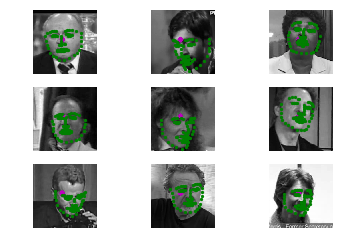

In [75]:
# visualize the output, 默认: shows a batch of 10 images;
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    for i in range(batch_size-1):
#         plt.figure() # figsize=(20,20)
#         plt.subplots(figsize=(20, 10))
        ax = plt.subplot(3, batch_size/3, i+1)  # 1, batch_size, i+1
#         subplot('position',[0.2,0.2,0.5,0.5])
        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0)) # transpose to go from torch to numpy image
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        # Call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        plt.axis('off')
    plt.show()
    
# Call it;
visualize_output(test_images, test_outputs, gt_pts)

## 16.训练

#### 损失函数
训练一个用于预测关键点的网络与训练一个用于预测类的网络不同。你可能希望选择适合回归的损失函数，而不是输出类的分布并使用交交叉熵损失函数，因为损失函数可以用于直接比较预测值和目标值。有关各种损失函数（如MSE或L1 / SmoothL1损失），请阅读 [本文档](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html)中的内容。

### TODO: 定义损失与优化

接下来，你需要通过定义损失函数和优化程序来定义模型的训练方式。

## 17.训练与初步观察

现在，你要使用大量epoch，从`train_loader`中训练你的批量训练数据。

为了快速观察你的模型是如何训练并决定是否应该修改它的结构或超参数，我们建议你最开始的时候使用一个或两个epoch。训练时，请注意观察模型的损失会如何随着时间的推移而变化：例如，它会先快速减少然后再减慢吗？或者起初会在一段时间后出现减少？如果更改了训练数据的批量大小或修改损失函数，会发生什么变化？

在使用多个epoch进行训练并创建最终模型之前，使用这些初始观察值对模型进行更改并确定一个最佳架构。

In [26]:
## TODO: Define the loss and optimization
import torch.optim as optim
criterion = nn.MSELoss() # None, the loss;
optimizer = optim.Adam(params = net.parameters(), lr=0.001) # None

# 定义训练函数;
def train_net(n_epochs):
    # prepare the net for training
    net.train()
    print(time.strftime('%Y-%m-%d %H:%M:%S GMT-0',time.localtime(time.time())))
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            # forward pass to get outputs
            output_pts = net(images)
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            # backward pass to calculate the weight gradients
            loss.backward()
            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 20 == 19:    # print every 10/40/20 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
        print(time.strftime('%Y-%m-%d %H:%M:%S GMT-0',time.localtime(time.time())))

    print('Finished Training.')

In [ ]:
# 注: 此cell中的代码并未运行, 原因: 太耗时, 方案: 使用之前已保存的模型;
print(time.strftime('%Y-%m-%d %H:%M:%S GMT-0',time.localtime(time.time())))
# Train the face detection CNN;
# start small, and increase when you've decided on your model structure and hyperparams
n_epochs = 35 # Training takes long time, use value 1 for test/try, before: value 3;
# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs) # 在active_session()之内训练, train_net();
## TODO: change the name to something uniqe for each new model
model_dir  = 'saved_models/'
# 模型(参数)保存名称的文件名;
model_name = 'keypoints_model_6_EPOCH-35.pt'    # 'keypoints_model_1.pt'
# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)
print('Finished Saving The Model.')
print(time.strftime('%Y-%m-%d %H:%M:%S GMT-0', time.localtime(time.time())))
# 例: 训练输出, 以下;
# .
# .
# Epoch: 35, Batch: 300, Avg. Loss: 0.0755069924518466
# Epoch: 35, Batch: 320, Avg. Loss: 0.07450148947536946
# Epoch: 35, Batch: 340, Avg. Loss: 0.08070245124399662
# 2019-03-31 23:52:28 GMT-0
# Finished Training.
# Finished Saving The Model.
# 2019-03-31 23:52:28 GMT-0

In [ ]:
# 注: 以及这个训练10个epochs的cell;
# train your network
# start small, and increase when you've decided on your model structure and hyperparams
n_epochs = 10    # Training takes long time, use value 1 for test/try, before: value 3;
# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)
## TODO: change the name to something uniqe for each new model
model_dir  = 'saved_models/'
model_name = 'keypoints_model_5_EPOCH-10.pt'    # 'keypoints_model_1.pt'
# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)
print('Finished Saving The Model.')
# 训练样例输出;
# .
# .
# Epoch: 10, Batch: 320, Avg. Loss: 0.11771331690251827
# Epoch: 10, Batch: 340, Avg. Loss: 0.10714615527540446
# Finished Training.
# Finished Saving The Model.

## 18.测试数据

在这部分, 将测试模型在之前未见过的测试数据上的表现, 我们已经对测试数据进行加载与转换，这一点类似于与训练数据时的做法类似。接下来，在这些图像上运行已被训练的模型，查看其生成的关键点类型.

**注意**: 1.应该能够观察模型是否拟合了它看到的每个新人脸, 2.这些点是否是随机分布的, 3.这些点实际上是否过度拟合了训练数据而没有进行归纳.

In [28]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())
# 由于此notebook并没有实际进行模型训练, 故此处不再调用visualize_output()进行测试;
# ## TODO: visualize your test output, use the same function as before:
# visualize_output(test_images, test_outputs, gt_pts)

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [30]:
# 从保存的模型文件中加载模型;
import torch
from models import Net

net = Net()
## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
# keypoints_model_5_EPOCH-10, keypoints_model_6_EPOCH-35
net.load_state_dict(torch.load('saved_models/keypoints_model_6_EPOCH-35.pt'))
# Or 'keypoints_model_march_1.pt', keypoints_model_1.pt,
## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop5): Dropout(p=0.5)
  (drop6): Dropout(p=0.6)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)

[[-0.08786873 -0.14609374  0.11438023  0.10828431  0.19157574]
 [-0.11758713  0.09760319  0.03204373 -0.14082327  0.1138932 ]
 [-0.05186836  0.00412108 -0.1004694   0.09472279  0.0407616 ]
 [-0.19402166  0.05524991  0.07547362 -0.27060249 -0.25046173]
 [-0.2604669  -0.07852212  0.03834381 -0.06471518 -0.26590955]]
(5, 5)


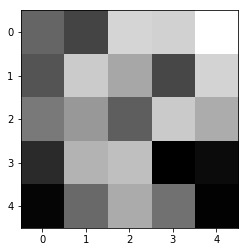

In [33]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data
w = weights1.numpy()
# 第index=0个filter;
filter_index = 0
print(w[filter_index][0])
print(w[filter_index][0].shape)
# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

## 19.特征映射

每个CNN至少包含一个由堆叠滤波器(也称为卷积核)组成的卷积层。CNN在进行训练时，它要学习在卷积内核中包含哪些权重，当这些内核应用于某些输入图像时，它们会产生一组**特征映射**。因此，特征映射只是过滤图像的集合，它们是通过将卷积核应用于输入图像而产生的图像。这些映射向我们展示了神经网络不同层学习提取的特征。例如，你可以想象一个卷积内核，它可以检测到脸部的垂直边缘，而另一个可以检测到眼角的边缘。通过将这些内核应用于图像，你可以看到每个内核检测到了哪些特征。具体请看以下示例，从它在图像中显示线条的方式，你可以将其表征为边缘检测滤波。接下来，选择一个测试图像并使用已被训练的CNN中的一个卷积内核对其进行过滤。查看过滤后的输出，了解该内核检测到的内容。

<img src='images/feature_map_ex.png' width=50% height=50%/>

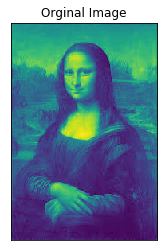

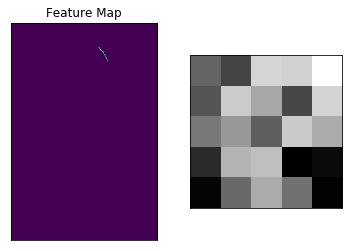

In [34]:
# TODO: 过滤图像，查看卷积内核的效果;
# Load in and display any image from the transformed test dataset
import cv2
# Loading the image
image = cv2.imread('./images/mona_lisa.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    # cv2.COLOR_BGR2RGB
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.title("Orginal Image")

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image;
filtered = cv2.filter2D(image, -1, w[filter_index][0])  # or w[filter_index][0], w[1][0]
fig = plt.figure()
ax  = fig.add_subplot(121, xticks = [], yticks = [])
ax.imshow(filtered)
ax.set_title("Feature Map")
ax  = fig.add_subplot(122, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')  # w[filter_index][0], w[1][0]

plt.show()

# Part 3
## 20.人脸与人脸关键点检测(有了人脸图像才有人脸检测)

在训练用于检测面部关键点的神经网络之后，你可以将此网络应用于包含人脸的*任何一个*图像。该神经网络需要一定大小的Tensor作为输入，因此，要检测任何一个人脸，你都首先必须进行一些预处理。

1. 使用人脸检测器检测图像中的所有人脸。在这个notebook中，我们将使用Haar级联检测器。
2. 对这些人脸图像进行预处理，使其成为灰度图像，并转换为你期望的输入尺寸的张量。这个步骤与你在Notebook 2中创建和应用的`data_transform` 类似，其作用是重新缩放、归一化，并将所有图像转换为Tensor，作为CNN的输入。
3. 使用已被训练的模型检测(人脸)图像上的人脸关键点。

In [35]:
# Helper Function;
def show_all_keypoints_new(image, keypoints):
    plt.figure(figsize=(5,5))
    keypoints = keypoints.data.numpy()
    # Becuase of normalization, keypoints won't be placed if they won't reutrn to values before noramlization;
    keypoints = keypoints * 60.0 + 96  # - ;
    keypoints = np.reshape(keypoints, (68,-1))
    image = image.numpy()
    image = np.transpose(image, (1,2,0))
    image = np.squeeze(image)  # 去掉秩为1的array维度;
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[:,0], keypoints[:,1], s=40, marker='.', c='m')

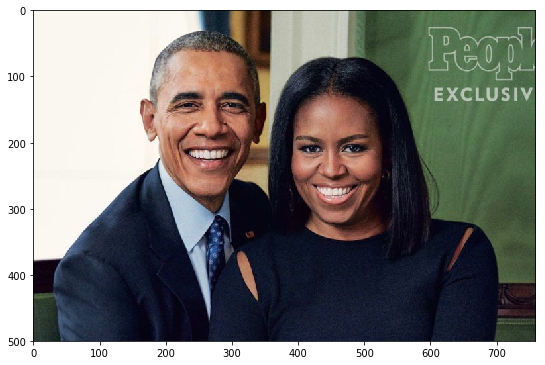

In [41]:
# 加载项目此部分所需的库;
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')  # obamas.jpg, the_beatles.jpg, mona_lisa.jpg
# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plot the image;
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## 21.检测该图像中的所有人脸

要想检测到所选图像中的所有人脸，接下来，你要用到的是OpenCV预先训练的一个Haar级联分类器，所有这些分类器都可以在`detector_architectures/`目录中找到。

在下面的代码中，我们要遍历原始图像中的每个人脸，并在原始图像的副本中的每个人脸上绘制一个红色正方形，而原始图像不需要修改。此外，你也可以 [新增一项眼睛检测 ](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) ，作为使用Haar检测器的一个可选练习。下面是各种图像上的人脸检测示例。

<img src='images/haar_cascade_ex.png' width=80% height=80%/>

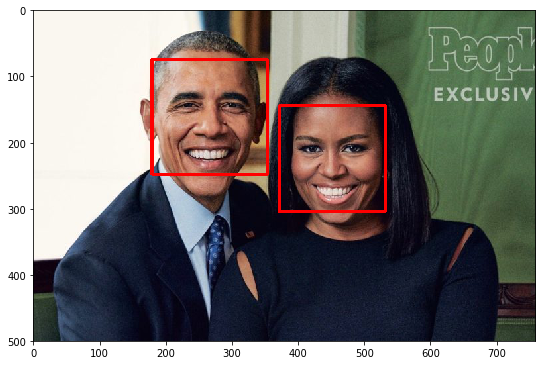

In [42]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)
# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))
plt.imshow(image_with_detections)

## 22.加载到已训练的模型中

有了一个可以使用的图像后（在这里，你可以选择`images/`目录中的任何一张人脸图像），下一步是对该图像进行预处理并将其输入进**CNN人脸关键点检测器**。首先，按文件名加载你选定的最佳模型(见之前的cell)。


## 23.关键点检测

现在，我们需要再一次遍历图像中每个检测到的人脸，只是这一次，你需要将这些人脸转换为CNN可以接受的张量形式的输入图像。

### TODO: 将每个检测到的人脸转换为输入Tensor

你需要对每个检测到的人脸执行以下操作：
1. 将人脸从RGB图转换为灰度图
2. 把灰度图像归一化，使其颜色范围落在[0,1]范围，而不是[0,255]
3. 将检测到的人脸重新缩放为CNN的预期方形尺寸（我们建议为 224x224）
4. 将numpy图像变形为torch图像。

**提示**: Haar检测器检测到的人脸大小与神经网络训练过的**人脸大小不同**。如果你发现模型生成的关键点对给定的人脸来说，显得太小，请尝试在检测到的`roi`中添加一些填充，然后将其作为模型的输入。

你可能会发现，参看`data_load.py`中的转换代码对帮助执行这些处理步骤很有帮助。


### TODO: 检测并显示预测到的关键点

将每个人脸适当地转换为网络的输入Tensor之后，就可以将`net` 应用于每个人脸。输出应该是预测到的人脸关键点，这些关键点需要“非归一化”才能显示。你可能会发现，编写一个类似`show_keypoints`的辅助函数会很有帮助。最后，你会得到一张如下的图像，其中人脸关键点与每张人脸上的面部特征非常匹配：

<img src='images/michelle_detected.png' width=30% height=30%/>

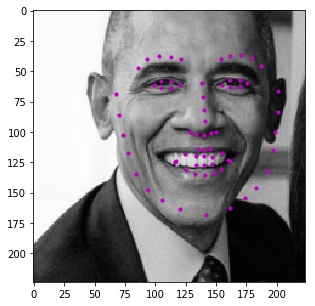

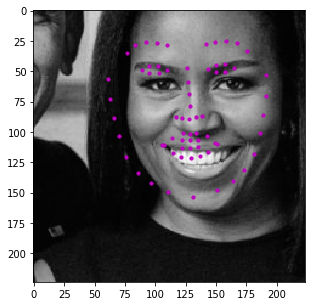

In [43]:
from torch.autograd import Variable

image_copy = np.copy(image)
# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    # Select the Region Of Interest that is the face in the image, 拷贝一份人脸的区域;
    # roi = image_copy[y:y+h, x:x+w]
    roi = image_copy[y:y+int(1.5*h), x-int(0.4*w):x+int(1.1*w)]  # 扩大人脸face在图片region的范围;
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi / 255.
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = np.expand_dims(roi, 0)
    roi = np.expand_dims(roi, 0)
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    roi_torch = Variable(torch.from_numpy(roi))    # 将roi区域生成为torch变量;
    roi_torch = roi_torch.type(torch.FloatTensor)  # 将torch变量的值转换一下: FloatTensor;
    keypoints = net(roi_torch)                     # net对象生成region图片内的keypoints;
    ## TODO: Display each detected face and the corresponding keypoints        
    show_all_keypoints_new(roi_torch.squeeze(0), keypoints)  # 在region图片内绘制keypoints点;

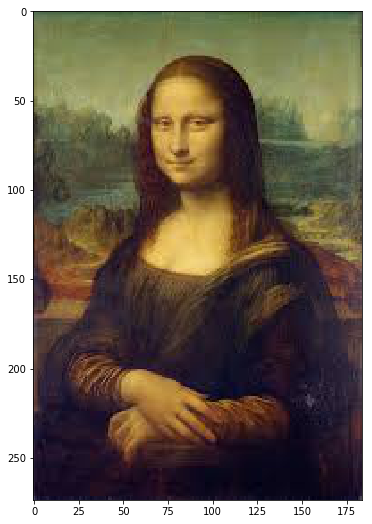

In [44]:
# load in color image for face detection
image_mona_lisa = cv2.imread('images/mona_lisa.jpg')  # obamas.jpg, the_beatles.jpg, mona_lisa.jpg
# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image_mona_lisa = cv2.cvtColor(image_mona_lisa, cv2.COLOR_BGR2RGB)
# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image_mona_lisa)

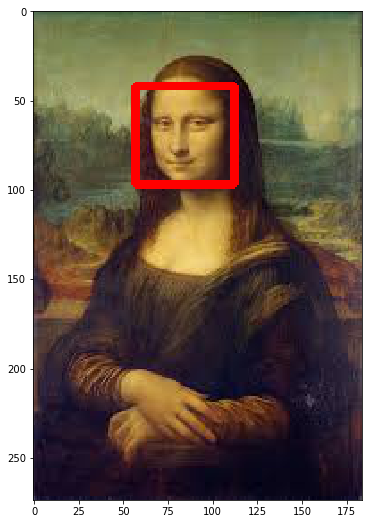

In [45]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image_mona_lisa, 1.2, 2)
# make a copy of the original image to plot detections on
image_with_detections = image_mona_lisa.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))
plt.imshow(image_with_detections)

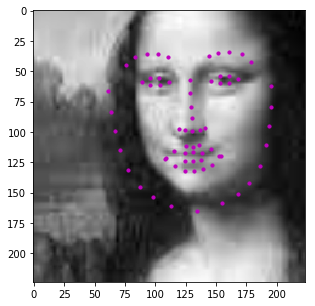

In [47]:
image_copy = np.copy(image_mona_lisa)
# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    # Select the region of interest that is the face in the image
    # roi = image_copy[y:y+h, x:x+w]
    roi = image_copy[y:y+int(1.5*h), x-int(0.4*w):x+int(1.1*w)]
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi / 255.
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = np.expand_dims(roi, 0)
    roi = np.expand_dims(roi, 0)
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    roi_torch = Variable(torch.from_numpy(roi))
    roi_torch = roi_torch.type(torch.FloatTensor)
    keypoints = net(roi_torch)
    ## TODO: Display each detected face and the corresponding keypoints        
    show_all_keypoints_new(roi_torch.squeeze(0), keypoints)